In [1]:
#!pip install transformers datasets torch ipywidgets matplotlib seaborn

In [1]:
from datasets import load_dataset

dataset = load_dataset("boolq")

# Attention redundancy matrix

In [2]:
from tqdm import tqdm

input_pairs = [[row['question'], row['passage']] for row in dataset['train']]
#tokenized_inputs = [tokenizer(text_pairs[0], text_pairs[1], truncation=True, padding=True, max_length=512) for text_pairs in input_pairs]



In [3]:
import torch
import numpy as np

# Computes average cosine similarity for each input
def compute_distances_for_all_pairs(attention_matrices):
    """
    Compute the cosine similarities across the attention matrices generated for a singular input

    Args:
    - inputs atention matrix.

    Returns:
    - Similarity scores for all pairs of attention heads in the input (expected no_of_attention_head_pairs C 2).
    """
    # Assume attention_matrices is of shape (144, n, n)
    num_attention_matrices, n_tokens, _ = attention_matrices.shape
    distances = []

    for i in range(num_attention_matrices):
        for j in range(i + 1, num_attention_matrices):
            total_distance = 0
            for token_idx in range(n_tokens):
                vector_a = attention_matrices[i, token_idx, :].flatten()
                vector_b = attention_matrices[j, token_idx, :].flatten()

                # Compute cosine similarity
                dot_product = np.dot(vector_a, vector_b)
                norm_a = np.linalg.norm(vector_a)
                norm_b = np.linalg.norm(vector_b)
                similarity = dot_product / (norm_a * norm_b)

                total_distance += similarity

            avg_distance = total_distance / n_tokens
            distances.append(avg_distance)

    return distances


In [4]:
# Iterate through all input pairs and extract attention matrix
def compute_cosine_sim_for_all_inputs(inputs_list):
  all_avg_similarities = []
  for input_pairs in tqdm(inputs_list, desc='Pairs of inputs'):
    tokenized_input = tokenizer(input_pairs[0], input_pairs[1], truncation=True, padding=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
      outputs = model(**tokenized_input)

    attention_outputs = torch.stack(outputs.attentions)
    #attention_outputs = attention_outputs.cpu()
    flattened_attention_matrices = attention_outputs.view(-1, attention_outputs.size(3), attention_outputs.size(4))

    final_scalar_values = compute_distances_for_all_pairs(flattened_attention_matrices.numpy())
    all_avg_similarities.append(final_scalar_values)

  return all_avg_similarities

In [5]:
import torch
#from transformers import AutoTokenizer, BertForSequenceClassification

# Base-BERT
'''tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity", output_attentions=True)'''

#DISTILBERT
'''from transformers import AutoTokenizer, DistilBertModel
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased", output_attentions=True)'''

#BERT-large
'''from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained("bert-large-uncased", output_attentions=True)'''

'''#Fine-tuned BERT BoolQ
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("rycecorn/bert-fine-tuned-boolq")
model = AutoModelForSequenceClassification.from_pretrained("rycecorn/bert-fine-tuned-boolq", output_attentions=True)'''

'''# Fine-tuned DistilBERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_link = "rycecorn/distil-bert-fine-tuned-boolq"
tokenizer = AutoTokenizer.from_pretrained(model_link)
model = AutoModelForSequenceClassification.from_pretrained(model_link, output_attentions=True)'''

# Roberta BASE
from transformers import AutoTokenizer, RobertaModel
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = RobertaModel.from_pretrained("FacebookAI/roberta-base")

# note to self:
test_ten_pairs = compute_cosine_sim_for_all_inputs(input_pairs[:1000])
## output has dim (N, num_pairs)

# try creating a function that just takes in input and then directly outputting the attention matrices, possible error when taking the vectorized text as input

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Pairs of inputs: 100%|██████████| 1000/1000 [55:21<00:00,  3.32s/it] 


In [6]:
import pickle
import json

with open('boolq_cosine_sim_Roberta-base_BoolQ_1000.pkl', 'wb') as file:
    pickle.dump(test_ten_pairs, file)
    
'''with open('boolq_cosine_sim_attention_redundant_1000.pkl', 'rb') as file:
    ahr_values = pickle.load(file)
    print(np.array(ahr_values).shape)'''

"with open('boolq_cosine_sim_attention_redundant_1000.pkl', 'rb') as file:\n    ahr_values = pickle.load(file)\n    print(np.array(ahr_values).shape)"

## AHR visualization

In [7]:
average_correlation_across_inputs = [sum(values) / len(values) for values in zip(*test_ten_pairs)]
print(len(average_correlation_across_inputs))

2556


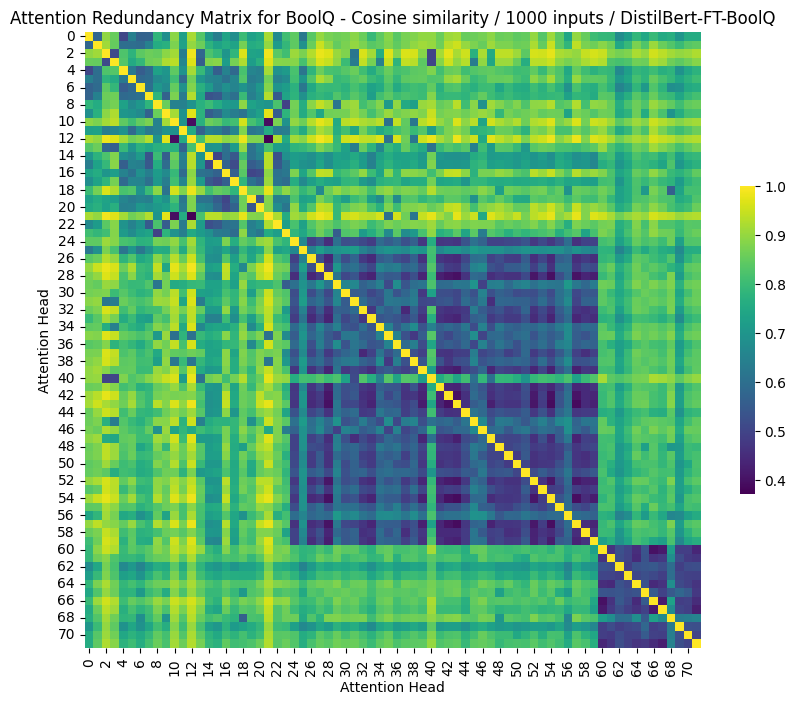

In [8]:
# Attention redundancy matrix

# Number of attention heads
num_heads = 144

# Convert distances to similarities
# Example using exponential decay, adjust based on your preference
similarities = np.exp(-np.array(average_correlation_across_inputs))

# Initialize the redundancy matrix with zeros
redundancy_matrix = np.zeros((num_heads, num_heads))

# Fill the redundancy matrix
k = 0
for i in range(num_heads):
    for j in range(i+1, num_heads):
        redundancy_matrix[i, j] = similarities[k]
        redundancy_matrix[j, i] = similarities[k]  # Symmetric
        k += 1

# Optionally, set the diagonal to the maximum similarity score
np.fill_diagonal(redundancy_matrix, 1)

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming redundancy_matrix is already defined as shown in the previous step
# Visualizing the attention redundancy matrix

plt.figure(figsize=(10, 8))
sns.heatmap(redundancy_matrix, cmap='viridis', annot=False, square=True, cbar_kws={'shrink': .5})
plt.title('Attention Redundancy Matrix for BoolQ - Cosine similarity / 1000 inputs / Roberta-Base')
plt.xlabel('Attention Head')
plt.ylabel('Attention Head')
plt.savefig('ahr_boolq_cosine_sim_Roberta-Base-BoolQ_1000.png')
plt.show()